# Анализ данных о криптовалютах полученных с CryptoRank.io и bscscan.com

## 1.Извлечение данных из json

In [66]:
import json
import pandas as pd
import sys

# Функция для конвертации данных из JSON в DataFrame и сохранения в CSV файл
def to_df(filename):
    # Открываем JSON файл для чтения
    with open(filename, 'r', encoding='utf-8') as json_file:
        # Загружаем данные из JSON файла
        data = json.load(json_file)

    # Создаем DataFrame из данных
    df = pd.DataFrame(data)

    # Сохраняем DataFrame в CSV файл с тем же именем, что и у исходного JSON файла, но с расширением .csv
    df.to_csv(f'{filename.split(".json")[0]}.csv', index=False, sep=';')

    # Возвращаем DataFrame
    return df

# Вызываем функцию to_df для файла 'coin_data.json'
scan = to_df('coin_data.json')

# Открываем JSON файл 'contract_data.json' для чтения
with open("contract_data.json", 'r') as json_file:
    # Загружаем данные из JSON файла
    data = json.load(json_file)

In [67]:
# Функция для извлечения информации о монете из словарей
def extract_coin_info(item):
    if item is not None and 'props' in item and 'pageProps' in item['props']:
        return item['props']['pageProps']
    else:
        return None

# Создание нового датафрейма на основе информации о монете
coin_df = pd.json_normalize(scan['items'].apply(extract_coin_info).dropna())
coin_df

,rank,key,name,hasFundingRounds,symbol,type,lifeCycle,unlimitedSupply,totalSupply,percentOfCircSupply,...,histPrices.3Y.BTC,histPrices.3Y.ETH,histPrices.3Y.percentUSD,icoData.kyc,icoData.accepting,icoData.whitelist,icoData.teamFromCountries,athPrice.dateUSD,icoData.rates,isSponsored
0,NaN,patex,Patex,False,PATEX,token,crowdsale,False,8.000000e+06,4.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1716.0,cyber-arena,Cyber Arena,False,CAT,token,traded,False,5.000000e+09,14.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1699.0,virtual-versions,Virtual Versions,False,VV,token,traded,False,1.000000e+09,11.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1595.0,kryptonite,Kryptonite,False,SEILOR,token,traded,False,1.000000e+09,19.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1120.0,spartadex,SpartaDEX,False,SPARTA,token,traded,False,1.000000e+08,18.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,NaN,nft-alley,NFT Alley,True,ALLEY,token,traded,False,1.000000e+07,86.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2716,NaN,algopainter,AlgoPainter,False,ALGOP,token,inactive,False,1.000000e+08,10.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2717,1365.0,mydefipet,MyDeFiPet,True,DPET,token,traded,False,1.000000e+08,50.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2718,1814.0,mist-nft,Mist,False,MIST,token,traded,False,1.000000e+09,5.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Определим число уникальных данных, продолжать работу будем с ними**

In [68]:
unique_keys_count = coin_df['key'].nunique()
print("Number of unique values in the 'key' column:", unique_keys_count)

Number of unique values in the 'key' column: 1424


столбцов 247 - это очень много, определим возможные признаки 

name - наименование криптовалюты

hasFundingRounds - Раунды финансирования могут включать предварительные продажи токенов (Initial Coin Offerings, ICO), частные раунды, а также последующие этапы привлечения средств. 

links - ссылки на веб-сайты, используется для создания признака is_web_live

volume24hUsd - обьем продаж в день получения данных(NaN = 0)

totalSupply - число монет "напечатанных станком"

percentOfCircSupply - процент от этого числа, циркулирующий в экономике

historyStartDay - момент начала продажи криптовалюты - дата(NaN - значит что криптовалюта ещё готовиться к продажам)

lifeCycle - crowdsale - подготовка к продажам, traded - "в экономике", inactive - означает что криптовалюта мертва её никто не покупает и не продаёт.
(в принципе это значит, что от данных crowdsale можно избавиться до запуска проекта. А traded и inactive это и есть то, что мы предсказываем)

In [69]:
threshold = 0.1 * len(coin_df)
df_cleaned = coin_df.dropna(axis=1, thresh=threshold)
yes_columns = ['name', 'hasFundingRounds', 'links', 'volume24hUsd', 'totalSupply', 'percentOfCircSupply', 'historyStartDay', 'lifeCycle']
df_cleaned = df_cleaned[yes_columns]
df_cleaned

,key,name,hasFundingRounds,links,volume24hUsd,totalSupply,percentOfCircSupply,historyStartDay,lifeCycle
0,patex,Patex,False,"[{'type': 'web', 'value': 'https://patex.io/'}...",NaN,8.000000e+06,4.21,NaN,crowdsale
1,cyber-arena,Cyber Arena,False,"[{'type': 'web', 'value': 'https://www.cyber-a...",29920.120165,5.000000e+09,14.95,2023-10-05,traded
2,virtual-versions,Virtual Versions,False,"[{'type': 'web', 'value': 'https://virtualvers...",663475.492992,1.000000e+09,11.29,2023-09-12,traded
3,kryptonite,Kryptonite,False,"[{'type': 'discord', 'value': 'https://discord...",36897.969515,1.000000e+09,19.30,2023-08-14,traded
4,spartadex,SpartaDEX,False,"[{'type': 'web', 'value': 'https://spartadex.i...",34726.685377,1.000000e+08,18.70,2023-08-08,traded
...,...,...,...,...,...,...,...,...,...
2715,nft-alley,NFT Alley,True,"[{'type': 'web', 'value': 'https://nftalley.io...",11.203164,1.000000e+07,86.99,2021-05-20,traded
2716,algopainter,AlgoPainter,False,"[{'type': 'web', 'value': 'https://www.algopai...",NaN,1.000000e+08,10.00,2021-05-20,inactive
2717,mydefipet,MyDeFiPet,True,"[{'type': 'whitepaper', 'value': 'https://www....",68614.753369,1.000000e+08,50.23,2021-05-14,traded
2718,mist-nft,Mist,False,"[{'type': 'web', 'value': 'https://mist.game/'...",71808.588700,1.000000e+09,5.64,2021-04-17,traded


Снизу все данные которые мы можем использовать

In [ ]:
print(list(coin_df.columns))

Добавим ещё столбец - код криптовалюты, для этого получим данные из json, создадим dataFrame и смерджим его с нашим по именам

In [72]:
n_data = list()
n_data = []
for key in data:
    if data[key] == []:
        continue
    n_data.append({'name' : key, 'code' : data[key]['result'][0]})

In [73]:
codes = pd.DataFrame(n_data)

In [74]:
codes

,name,code
0,Patex,{'SourceCode': '// OpenZeppelin Contracts v4.4...
1,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...
2,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ..."
3,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ..."
4,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ..."
...,...,...
1166,Polylastic,"{'SourceCode': '{{ ""language"": ""Solidity"", ..."
1167,NFT Alley,{'SourceCode': '// File: openzeppelin-solidity...
1168,AlgoPainter,{'SourceCode': '// File: @openzeppelin/contrac...
1169,Mist,"{'SourceCode': '{{ ""language"": ""Solidity"", ..."


In [75]:
result_df = pd.merge(codes, df_cleaned.drop_duplicates('name'), on='name', how='left')
result_df

,name,code,key,hasFundingRounds,links,volume24hUsd,totalSupply,percentOfCircSupply,historyStartDay,lifeCycle
0,Patex,{'SourceCode': '// OpenZeppelin Contracts v4.4...,patex,False,"[{'type': 'web', 'value': 'https://patex.io/'}...",NaN,8.000000e+06,4.21,NaN,crowdsale
1,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...,cyber-arena,False,"[{'type': 'web', 'value': 'https://www.cyber-a...",29920.120165,5.000000e+09,14.95,2023-10-05,traded
2,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",virtual-versions,False,"[{'type': 'web', 'value': 'https://virtualvers...",663475.492992,1.000000e+09,11.29,2023-09-12,traded
3,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",kryptonite,False,"[{'type': 'discord', 'value': 'https://discord...",36897.969515,1.000000e+09,19.30,2023-08-14,traded
4,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",spartadex,False,"[{'type': 'web', 'value': 'https://spartadex.i...",34726.685377,1.000000e+08,18.70,2023-08-08,traded
...,...,...,...,...,...,...,...,...,...,...
1166,Polylastic,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",polylastic,True,"[{'type': 'web', 'value': 'https://polylastic....",293938.399090,9.825410e+10,72.91,2021-05-10,traded
1167,NFT Alley,{'SourceCode': '// File: openzeppelin-solidity...,nft-alley,True,"[{'type': 'web', 'value': 'https://nftalley.io...",11.203164,1.000000e+07,86.99,2021-05-20,traded
1168,AlgoPainter,{'SourceCode': '// File: @openzeppelin/contrac...,algopainter,False,"[{'type': 'web', 'value': 'https://www.algopai...",NaN,1.000000e+08,10.00,2021-05-20,inactive
1169,Mist,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",mist-nft,False,"[{'type': 'web', 'value': 'https://mist.game/'...",71808.588700,1.000000e+09,5.64,2021-04-17,traded


Создание признака is_web_live, True если получилось достучаться до web страницы, и false в противном случае

In [76]:
import requests
cnt = 0
def is_web_live(url):
    global cnt
    cnt += 1
    print(cnt)
    try:
        response = requests.get(url)
        return response.status_code == 200
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return False

result_df['is_web_live'] = result_df['links'].apply(
    lambda x: is_web_live([link['value'] for link in x if link['type'] == 'web'][0]) if any(link['type'] == 'web' for link in x) else False
)
result_df.drop('links', axis=1)
result_df

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
An error occurred: HTTPSConnectionPool(host='fantommaker.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
An error occurred: HTTPSConnectionPool(host='envoy.art', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000026A85FD6F50>: Failed to resolve 'envoy.art' ([Errno 11001] getaddrinfo failed)"))
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
An error occurred: HTTPSConnectionPool(host='www.gamestarter.co', port=443): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000026A88A328D0>, 'Connection to www.gamestarter.co timed out. (connect timeout

,name,code,key,hasFundingRounds,links,volume24hUsd,totalSupply,percentOfCircSupply,historyStartDay,lifeCycle,is_web_live
0,Patex,{'SourceCode': '// OpenZeppelin Contracts v4.4...,patex,False,"[{'type': 'web', 'value': 'https://patex.io/'}...",NaN,8.000000e+06,4.21,NaN,crowdsale,True
1,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...,cyber-arena,False,"[{'type': 'web', 'value': 'https://www.cyber-a...",29920.120165,5.000000e+09,14.95,2023-10-05,traded,True
2,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",virtual-versions,False,"[{'type': 'web', 'value': 'https://virtualvers...",663475.492992,1.000000e+09,11.29,2023-09-12,traded,True
3,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",kryptonite,False,"[{'type': 'discord', 'value': 'https://discord...",36897.969515,1.000000e+09,19.30,2023-08-14,traded,True
4,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",spartadex,False,"[{'type': 'web', 'value': 'https://spartadex.i...",34726.685377,1.000000e+08,18.70,2023-08-08,traded,False
...,...,...,...,...,...,...,...,...,...,...,...
1166,Polylastic,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",polylastic,True,"[{'type': 'web', 'value': 'https://polylastic....",293938.399090,9.825410e+10,72.91,2021-05-10,traded,True
1167,NFT Alley,{'SourceCode': '// File: openzeppelin-solidity...,nft-alley,True,"[{'type': 'web', 'value': 'https://nftalley.io...",11.203164,1.000000e+07,86.99,2021-05-20,traded,False
1168,AlgoPainter,{'SourceCode': '// File: @openzeppelin/contrac...,algopainter,False,"[{'type': 'web', 'value': 'https://www.algopai...",NaN,1.000000e+08,10.00,2021-05-20,inactive,False
1169,Mist,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",mist-nft,False,"[{'type': 'web', 'value': 'https://mist.game/'...",71808.588700,1.000000e+09,5.64,2021-04-17,traded,True


In [78]:
result_df['code'][0]['SourceCode']

'// OpenZeppelin Contracts v4.4.1 (utils/Context.sol)\r\n\r\npragma solidity ^0.8.0;\r\n\r\n/**\r\n * @dev Provides information about the current execution context, including the\r\n * sender of the transaction and its data. While these are generally available\r\n * via msg.sender and msg.data, they should not be accessed in such a direct\r\n * manner, since when dealing with meta-transactions the account sending and\r\n * paying for execution may not be the actual sender (as far as an application\r\n * is concerned).\r\n *\r\n * This contract is only required for intermediate, library-like contracts.\r\n */\r\nabstract contract Context {\r\n    function _msgSender() internal view virtual returns (address) {\r\n        return msg.sender;\r\n    }\r\n\r\n    function _msgData() internal view virtual returns (bytes calldata) {\r\n        return msg.data;\r\n    }\r\n}\r\n\r\n// OpenZeppelin Contracts (last updated v4.6.0) (token/ERC20/IERC20.sol)\r\n\r\npragma solidity ^0.8.0;\r\n\r\n/**

Создание признака - pragma_version - версия компилятора языка solidity, который используется при создании криптовалют, что определяет функциальность и возможности доступные мошенникам(NaN означает что код криптовалюты не верифицирован - что не исключает возможности её существования, но не позволяет посмотреть код. Так же не говорит о том вредная монета или нет.)

In [79]:
import re
def extract_pragma_version(code_dict):
    source_code = code_dict.get('SourceCode', '')
    version_pattern = re.compile(r'pragma solidity[^;]+;\s*')
    match = version_pattern.search(source_code)
    
    if match:
        version_line = match.group(0)
        version_match = re.search(r'\d+\.\d+\.\d+', version_line)
        if version_match:
            return version_match.group(0)
    return None

# Применение функции к столбцу 'code' и создание нового столбца 'pragma_version'
result_df['pragma_version'] = result_df['code'].apply(extract_pragma_version)
result_df

,name,code,key,hasFundingRounds,links,volume24hUsd,totalSupply,percentOfCircSupply,historyStartDay,lifeCycle,is_web_live,pragma_version
0,Patex,{'SourceCode': '// OpenZeppelin Contracts v4.4...,patex,False,"[{'type': 'web', 'value': 'https://patex.io/'}...",NaN,8.000000e+06,4.21,NaN,crowdsale,True,0.8.0
1,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...,cyber-arena,False,"[{'type': 'web', 'value': 'https://www.cyber-a...",29920.120165,5.000000e+09,14.95,2023-10-05,traded,True,0.8.0
2,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",virtual-versions,False,"[{'type': 'web', 'value': 'https://virtualvers...",663475.492992,1.000000e+09,11.29,2023-09-12,traded,True,0.8.0
3,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",kryptonite,False,"[{'type': 'discord', 'value': 'https://discord...",36897.969515,1.000000e+09,19.30,2023-08-14,traded,True,0.8.0
4,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",spartadex,False,"[{'type': 'web', 'value': 'https://spartadex.i...",34726.685377,1.000000e+08,18.70,2023-08-08,traded,False,0.8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1166,Polylastic,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",polylastic,True,"[{'type': 'web', 'value': 'https://polylastic....",293938.399090,9.825410e+10,72.91,2021-05-10,traded,True,0.8.4
1167,NFT Alley,{'SourceCode': '// File: openzeppelin-solidity...,nft-alley,True,"[{'type': 'web', 'value': 'https://nftalley.io...",11.203164,1.000000e+07,86.99,2021-05-20,traded,False,0.6.0
1168,AlgoPainter,{'SourceCode': '// File: @openzeppelin/contrac...,algopainter,False,"[{'type': 'web', 'value': 'https://www.algopai...",NaN,1.000000e+08,10.00,2021-05-20,inactive,False,0.6.0
1169,Mist,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",mist-nft,False,"[{'type': 'web', 'value': 'https://mist.game/'...",71808.588700,1.000000e+09,5.64,2021-04-17,traded,True,0.5.1


In [80]:
result_df['code'][170]

{'SourceCode': '{{\r\n  "language": "Solidity",\r\n  "sources": {\r\n    "contracts/FinaToken.sol": {\r\n      "content": "// SPDX-License-Identifier: MIT\\r\\npragma solidity ^0.8.4;\\r\\n\\r\\nimport \\"@openzeppelin/contracts/token/ERC20/extensions/ERC20Burnable.sol\\";\\r\\nimport \\"@openzeppelin/contracts/token/ERC20/extensions/ERC20Pausable.sol\\";\\r\\nimport \\"@openzeppelin/contracts/access/AccessControlEnumerable.sol\\";\\r\\nimport \\"@openzeppelin/contracts/token/ERC20/extensions/ERC20Votes.sol\\";\\r\\n\\r\\ncontract FinaToken is AccessControlEnumerable, ERC20Burnable, ERC20Pausable, ERC20Votes {\\r\\n    \\r\\n    bytes32 public constant MINTER_ROLE = keccak256(\\"MINTER_ROLE\\");\\r\\n    bytes32 public constant BURNER_ROLE = keccak256(\\"BURNER_ROLE\\");\\r\\n    bytes32 public constant PAUSER_ROLE = keccak256(\\"PAUSER_ROLE\\");\\r\\n    uint256 public constant maxSupply = 100000000000000000000000000; //100 mil\\r\\n    string private constant TOKEN_NAME = \\"DEFINA T

In [86]:
result_df[result_df.columns].isna().sum()

name                     0
code                     0
key                      0
hasFundingRounds         0
links                    0
volume24hUsd             0
totalSupply              1
percentOfCircSupply    120
historyStartDay         37
lifeCycle                0
is_web_live              0
pragma_version          19
dtype: int64

Заполняем NaN-ы нулями, так как в этих признаках NaN имеет значение отсутствия.

In [87]:
result_df['percentOfCircSupply'].fillna(0, inplace=True)
result_df

,name,code,key,hasFundingRounds,links,volume24hUsd,totalSupply,percentOfCircSupply,historyStartDay,lifeCycle,is_web_live,pragma_version
0,Patex,{'SourceCode': '// OpenZeppelin Contracts v4.4...,patex,False,"[{'type': 'web', 'value': 'https://patex.io/'}...",0.000000,8.000000e+06,4.21,NaN,crowdsale,True,0.8.0
1,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...,cyber-arena,False,"[{'type': 'web', 'value': 'https://www.cyber-a...",29920.120165,5.000000e+09,14.95,2023-10-05,traded,True,0.8.0
2,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",virtual-versions,False,"[{'type': 'web', 'value': 'https://virtualvers...",663475.492992,1.000000e+09,11.29,2023-09-12,traded,True,0.8.0
3,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",kryptonite,False,"[{'type': 'discord', 'value': 'https://discord...",36897.969515,1.000000e+09,19.30,2023-08-14,traded,True,0.8.0
4,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",spartadex,False,"[{'type': 'web', 'value': 'https://spartadex.i...",34726.685377,1.000000e+08,18.70,2023-08-08,traded,False,0.8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1166,Polylastic,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",polylastic,True,"[{'type': 'web', 'value': 'https://polylastic....",293938.399090,9.825410e+10,72.91,2021-05-10,traded,True,0.8.4
1167,NFT Alley,{'SourceCode': '// File: openzeppelin-solidity...,nft-alley,True,"[{'type': 'web', 'value': 'https://nftalley.io...",11.203164,1.000000e+07,86.99,2021-05-20,traded,False,0.6.0
1168,AlgoPainter,{'SourceCode': '// File: @openzeppelin/contrac...,algopainter,False,"[{'type': 'web', 'value': 'https://www.algopai...",0.000000,1.000000e+08,10.00,2021-05-20,inactive,False,0.6.0
1169,Mist,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",mist-nft,False,"[{'type': 'web', 'value': 'https://mist.game/'...",71808.588700,1.000000e+09,5.64,2021-04-17,traded,True,0.5.1


In [88]:
result_df[result_df.columns].isna().sum()


name                    0
code                    0
key                     0
hasFundingRounds        0
links                   0
volume24hUsd            0
totalSupply             1
percentOfCircSupply     0
historyStartDay        37
lifeCycle               0
is_web_live             0
pragma_version         19
dtype: int64

Создание нового признака определяющего время от листинга криптовалюты, до текущей даты (5 категорий, crowdsale для ещё не запущенных)

In [95]:
from datetime import datetime, timedelta

# Преобразование столбца 'historyStartDay' в формат даты
result_df['historyStartDay'] = pd.to_datetime(result_df['historyStartDay'], errors='coerce')

# Определение текущей даты
current_date = datetime.now()

# Создание нового столбца с категориями
def categorize_date_diff(date):
    if pd.isnull(date):
        return 'crowdsale'
    
    time_diff = current_date - date
    
    if time_diff < timedelta(days=180):
        return 'less half'
    elif timedelta(days=180) <= time_diff < timedelta(days=365):
        return 'from half to one'
    elif timedelta(days=365) <= time_diff < timedelta(days=730):
        return 'from year to 2'
    else:
        return '2 and more'

result_df['years_from_start'] = result_df['historyStartDay'].apply(categorize_date_diff)
result_df = result_df.drop('historyStartDay', axis=1)

KeyError: 'historyStartDay'

In [96]:
result_df

,name,code,key,hasFundingRounds,links,volume24hUsd,totalSupply,percentOfCircSupply,lifeCycle,is_web_live,pragma_version,years_from_start
0,Patex,{'SourceCode': '// OpenZeppelin Contracts v4.4...,patex,False,"[{'type': 'web', 'value': 'https://patex.io/'}...",0.000000,8.000000e+06,4.21,crowdsale,True,0.8.0,crowdsale
1,Cyber Arena,{'SourceCode': '// File: @openzeppelin/contrac...,cyber-arena,False,"[{'type': 'web', 'value': 'https://www.cyber-a...",29920.120165,5.000000e+09,14.95,traded,True,0.8.0,less half
2,Virtual Versions,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",virtual-versions,False,"[{'type': 'web', 'value': 'https://virtualvers...",663475.492992,1.000000e+09,11.29,traded,True,0.8.0,less half
3,Kryptonite,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",kryptonite,False,"[{'type': 'discord', 'value': 'https://discord...",36897.969515,1.000000e+09,19.30,traded,True,0.8.0,less half
4,SpartaDEX,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",spartadex,False,"[{'type': 'web', 'value': 'https://spartadex.i...",34726.685377,1.000000e+08,18.70,traded,False,0.8.0,less half
...,...,...,...,...,...,...,...,...,...,...,...,...
1166,Polylastic,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",polylastic,True,"[{'type': 'web', 'value': 'https://polylastic....",293938.399090,9.825410e+10,72.91,traded,True,0.8.4,2 and more
1167,NFT Alley,{'SourceCode': '// File: openzeppelin-solidity...,nft-alley,True,"[{'type': 'web', 'value': 'https://nftalley.io...",11.203164,1.000000e+07,86.99,traded,False,0.6.0,2 and more
1168,AlgoPainter,{'SourceCode': '// File: @openzeppelin/contrac...,algopainter,False,"[{'type': 'web', 'value': 'https://www.algopai...",0.000000,1.000000e+08,10.00,inactive,False,0.6.0,2 and more
1169,Mist,"{'SourceCode': '{{ ""language"": ""Solidity"", ...",mist-nft,False,"[{'type': 'web', 'value': 'https://mist.game/'...",71808.588700,1.000000e+09,5.64,traded,True,0.5.1,2 and more


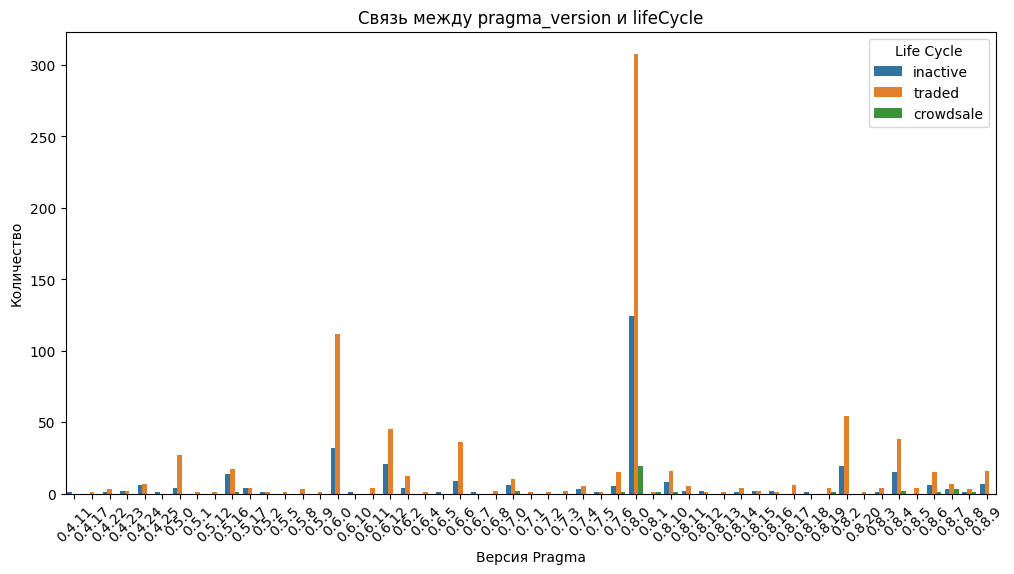

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
# Подсчет количества появлений каждой версии проги для каждого статуса жизненного цикла
data = result_df.groupby(['pragma_version', 'lifeCycle']).size().reset_index(name='count')
# Строим столбчатую диаграмму
plt.figure(figsize=(12, 6))
sns.barplot(x='pragma_version', y='count', hue='lifeCycle', data=data)
plt.title('Связь между pragma_version и lifeCycle')
plt.xlabel('Версия Pragma')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.legend(title='Life Cycle')
plt.show()

Объем продаж - избыточный признак его стоит убрать

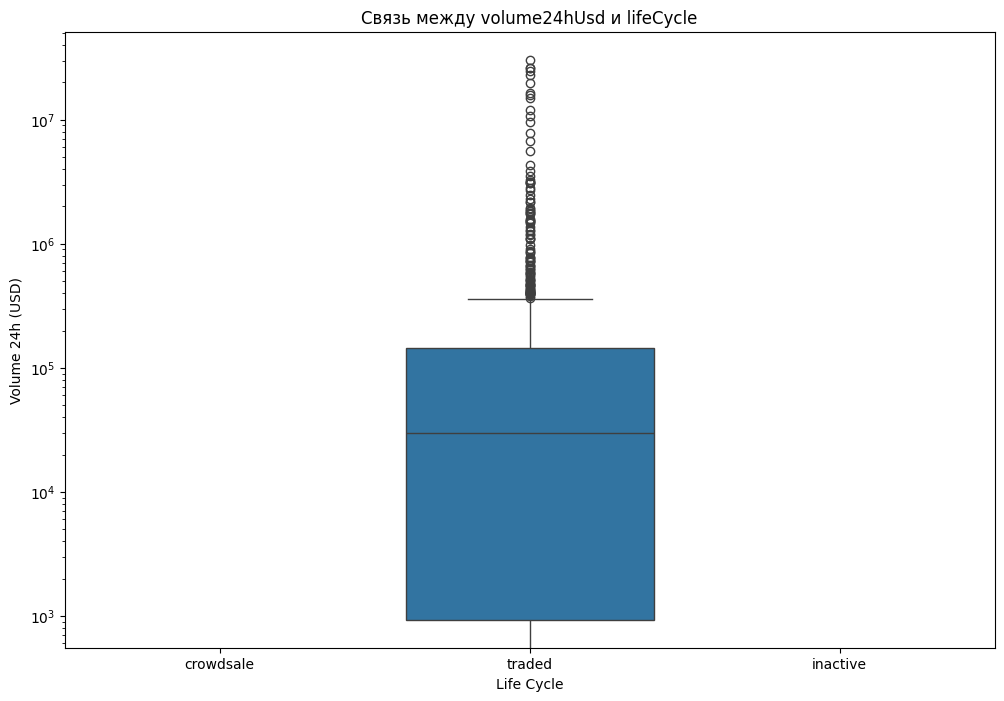

In [100]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='lifeCycle', y='volume24hUsd', data=result_df)
plt.yscale('log')  # Используем логарифмическую шкалу, так как объемы торгов могут варьироваться значительно
plt.title('Связь между volume24hUsd и lifeCycle')
plt.xlabel('Life Cycle')
plt.ylabel('Volume 24h (USD)')
plt.show()